In [1]:
# Import packages
import pandas as pd
import numpy as np
# %tensorflow_version 1.x
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
# from keras.layers.recurrent import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import keras
import seaborn as sns
import sklearn
import torch
import torch.nn as nn

2023-12-11 04:52:58.898951: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Import data

In [2]:
data_path = './Data/'

# read the pickled DataFrame from the specified path
df = pd.read_pickle('/root/shareWithContainer/DS-capstone_1021/data/weekday_re_df_1021.pkl')

# data preprocessing: set the date as the index and transpose rows and columns
df_transposed = df.transpose()

# convert the index to datetime objects
df_transposed.index = pd.to_datetime(df_transposed.index)

# check if the index has been successfully converted to datetime objects
is_all_datetime_index = isinstance(df_transposed.index, pd.DatetimeIndex)

print("Are all indices datetime objects? :", is_all_datetime_index)

# read additional DataFrames from CSV files
day_df = pd.read_csv(data_path+'day_unit_matrix.csv', encoding='utf-8')
weather_df = pd.read_csv(data_path+'weather_df.csv', encoding='cp949')

모든 인덱스가 datetime 객체인가요?: True


In [3]:
# drop the columns of Unnamed: 0
weather_df = weather_df.drop('Unnamed: 0', axis=1)

df_transposed = df_transposed.reset_index()

df_transposed = df_transposed.rename(columns={"index":"date"})
weather_df = weather_df.rename(columns={"일시":"date"})

# weather_df = weather_df.rename(columns={"일시":"date"})
weather_df['date'] = pd.to_datetime(weather_df['date'])

In [4]:
# normalization of weather data
# use StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
weather_df.iloc[:,1:] = scaler.fit_transform(weather_df.iloc[:,1:])

weather_df

,date,강수량(mm),최고기온(℃),평균기온(℃),최저기온(℃),일교차,평균습도(%rh),일조율(%),평균풍속(m/s),최대풍속(m/s)
0,2022-01-01,-0.261087,-1.459131,-1.607688,-1.726138,1.218467,-1.329248,1.175301,-1.275071,-1.561825
1,2022-01-02,-0.244983,-1.394395,-1.333590,-1.281421,-0.213968,-0.482545,0.072905,-0.099445,-0.126292
2,2022-01-03,-0.261087,-1.440635,-1.388410,-1.530462,0.552218,-0.453348,0.781378,-0.834211,-0.525051
3,2022-01-04,-0.261087,-1.579355,-1.443229,-1.316998,-0.746968,-0.927794,1.145903,0.047508,-0.445299
4,2022-01-05,-0.261087,-1.496123,-1.470639,-1.512673,0.285718,-1.234358,-1.005973,-0.981165,-1.482074
...,...,...,...,...,...,...,...,...,...,...
360,2022-12-27,-0.261087,-1.366651,-1.452366,-1.468202,0.585530,0.386056,1.113566,-0.834211,-1.242818
361,2022-12-28,-0.255719,-1.662587,-1.516322,-1.352575,-0.913530,-0.467946,1.081230,0.194461,0.112964
362,2022-12-29,-0.261087,-1.477627,-1.479776,-1.512673,0.352343,-0.599331,1.175301,-0.981165,-1.083314
363,2022-12-30,-0.261087,-1.459131,-1.379273,-1.210266,-0.713655,0.079491,0.837233,-0.687258,-0.126292


# Set the model : LSTM

In [20]:
# Set the parameter
n_input_features = 10 # number of feature

# the number of features in the hidden state
n_hidden_features = 20

# the number of recurrent layers
# e.g. 2 means stacking two RNNs to form a stacked RNN
n_layers = 3

# sequence length
sequence_length = 3

# Build Neural Network
class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.rnn = nn.RNN(
            input_size = n_input_features,
            hidden_size = n_hidden_features,
            num_layers = n_layers,
            nonlinearity = 'tanh',
            batch_first = True,
            dropout = 0,
            bidirectional = False
        )

        self.fc = nn.Sequential(
            nn.Linear(n_hidden_features * sequence_length, 1),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      
        # initial hidden state
        batch_size = x.shape[0]

        out1, hidden_state = self.rnn(x)
        out2 = out1.reshape(out1.shape[0], -1)
        out3 = self.fc(out2)
        return out3

model = Network()
print(model)

Network(
  (rnn): RNN(10, 20, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=60, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [24]:
from torch import optim

# set up an optimizer (pass parameters to be optimized and a learning rate)
optimizer = optim.Adam(
    model.parameters(),
    lr = 1e-3
)

n_epochs = 500

# define the loss
criterion = nn.MSELoss()

# Set Cuda : GPU

In [21]:
import torch

torch.cuda.is_available()

True

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [23]:
model.to(device)

Network(
  (rnn): RNN(10, 20, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=60, out_features=1, bias=True)
    (1): ReLU()
  )
)

# Training and Testing

In [25]:
def sequentize(x, y, sequence_length):

    x_seq = []
    y_seq = []
    
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i:i + sequence_length])   # i=2, a[2:7] -> 2,3,4,5,6
        y_seq.append(y[i + sequence_length])     # i=2, a[7]

    # use numpy array for faster conversion to tensor
    x_seq = np.array(x_seq)
    y_seq = np.array(y_seq)

    return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq).view(-1, 1)

In [26]:
import time
from sklearn.metrics import mean_squared_error

date = df_transposed['date']

Final_test_RMSE = []
Final_predict_values = []
Final_station = []

for column in df_transposed.columns[1:]:

    # make a DataFrame with date & rental count
    date_rental = pd.concat([date, df_transposed[column]], axis=1)

    # make a DataFrame with date_rental & weather
    df = pd.merge(date_rental, weather_df, on='date', how='left')
    df = df.set_index('date')

    # drop na
    df = df.dropna()

    # 3월부터 9월 데이터로 정리
    zero_df = df[df.index>='2022-03-01']

    first_df = zero_df[zero_df.index < '2022-10-01']

    # split the train and test data
    # train : 3 - 8 months
    # test : 9 month
    train_df = first_df[first_df.index<'2022-09-01']
    test_df = first_df[first_df.index>='2022-09-01']

    ## train_X, train_y, test_X, test_y 정리
    # X : rental value, weather
    # y : rental value
    X_train = train_df.iloc[:,:].values
    y_train = train_df.iloc[:,:1].values

    X_test = test_df.iloc[:,:].values
    y_test = test_df.iloc[:,:1].values

    # sliding window in train data
    # sequence length : 3
    train_x_seq, train_y_seq = sequentize(X_train, y_train, sequence_length)
    test_x_seq, test_y_seq = sequentize(X_test, y_test, sequence_length)

    # set the dataset
    trainset = torch.utils.data.TensorDataset(train_x_seq, train_y_seq)
    testset = torch.utils.data.TensorDataset(test_x_seq, test_y_seq)

    # loader for the training set
    batch_size = 32

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True
    )

    # Training
    start_time = time.time()

    for epoch in range(n_epochs):

        train_loss = 0

        model.train()

        for seqs, labels in trainloader:

            seqs, labels = seqs.to(device), labels.to(device)

            # zero the gradients on each training pass
            optimizer.zero_grad()

            # make a forward pass through the network
            out = model.forward(seqs)

            # use the network output to calculate the loss (output vs. ground truth)
            loss = criterion(out, labels)

            # make a backward pass through the network to calculate the gradients (backpropagation)
            loss.backward()

            # update the weights
            optimizer.step()

            # keep track of the loss per epoch
            train_loss += loss.item()

    print(f"Station: {column}")
    
    try:
        dataset = torch.utils.data.ConcatDataset([trainset, testset])

        # loader for the testset
        testloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=4
        )

        # loader for the testset
        testloader2 = torch.utils.data.DataLoader(
            testset,
            batch_size=4
        )

        # Test the data
        model.eval()

        preds = []
        actual_value = []
        rmses = []
        test_preds = []
        test_rmses = []

        with torch.no_grad():

            for seqs, labels in testloader:
                seqs, labels = seqs.to(device), labels.to(device)

                out = model.forward(seqs)

                rmses.append(
                    mean_squared_error(
                        labels.squeeze().cpu(), out.squeeze().cpu(),
                        squared = False
                    )
                )

                preds.extend(out.squeeze().cpu())

            for seqs, labels in testloader2:
                seqs, labels = seqs.to(device), labels.to(device)

                out = model.forward(seqs)

                test_rmses.append(
                    mean_squared_error(
                        labels.squeeze().cpu(), out.squeeze().cpu(),
                        squared = False
                    )
                )

                test_preds.extend(out.squeeze().cpu())

        # store a single test prediction in Final_predict_values
        Final_predict_values.append(test_preds)

        # save which station was predicted for each
        Final_station.append(column)

        # calculate and store the final test RMSE
        Final_test_RMSE.append(sum(test_rmses)/len(test_rmses))
    
    except:
        pass

Station: 3
Station: 4
Station: 5
Station: 6
Station: 7
Station: 8
Station: 9
Station: 10
Station: 11
Station: 12
Station: 13
Station: 14
Station: 15
Station: 17
Station: 18
Station: 19
Station: 20
Station: 21
Station: 22
Station: 23
Station: 24
Station: 25
Station: 26
Station: 27
Station: 28
Station: 29
Station: 30
Station: 31
Station: 32
Station: 33
Station: 34
Station: 35
Station: 36
Station: 37
Station: 38
Station: 39
Station: 40
Station: 41
Station: 42
Station: 43
Station: 44
Station: 45
Station: 46
Station: 47
Station: 48
Station: 49
Station: 50
Station: 51
Station: 52
Station: 53
Station: 54
Station: 55
Station: 56
Station: 57
Station: 58
Station: 59
Station: 60
Station: 61
Station: 62
Station: 63
Station: 64
Station: 65
Station: 66
Station: 67
Station: 68
Station: 69
Station: 70
Station: 71
Station: 72
Station: 73
Station: 74
Station: 75
Station: 76
Station: 77
Station: 78
Station: 79
Station: 80
Station: 81
Station: 82
Station: 83
Station: 84
Station: 85
Station: 86
Station: 87

Station: 653
Station: 654
Station: 655
Station: 656
Station: 657
Station: 658
Station: 659
Station: 660
Station: 661
Station: 662
Station: 663
Station: 664
Station: 665
Station: 666
Station: 667
Station: 668
Station: 669
Station: 670
Station: 671
Station: 672
Station: 673
Station: 674
Station: 675
Station: 676
Station: 677
Station: 678
Station: 679
Station: 680
Station: 681
Station: 682
Station: 683
Station: 684
Station: 685
Station: 686
Station: 687
Station: 688
Station: 689
Station: 690
Station: 691
Station: 692
Station: 693
Station: 694
Station: 695
Station: 696
Station: 697
Station: 698
Station: 699
Station: 700
Station: 701
Station: 702
Station: 703
Station: 704
Station: 705
Station: 706
Station: 707
Station: 708
Station: 709
Station: 710
Station: 711
Station: 712
Station: 713
Station: 714
Station: 715
Station: 717
Station: 718
Station: 719
Station: 720
Station: 721
Station: 722
Station: 723
Station: 724
Station: 725
Station: 726
Station: 727
Station: 728
Station: 729
Station: 730

Station: 1270
Station: 1271
Station: 1272
Station: 1273
Station: 1274
Station: 1275
Station: 1276
Station: 1277
Station: 1278
Station: 1279
Station: 1280
Station: 1281
Station: 1282
Station: 1283
Station: 1284
Station: 1285
Station: 1286
Station: 1287
Station: 1288
Station: 1289
Station: 1290
Station: 1291
Station: 1292
Station: 1293
Station: 1294
Station: 1295
Station: 1296
Station: 1297
Station: 1298
Station: 1300
Station: 1301
Station: 1302
Station: 1303
Station: 1304
Station: 1305
Station: 1306
Station: 1307
Station: 1308
Station: 1309
Station: 1310
Station: 1311
Station: 1312
Station: 1313
Station: 1314
Station: 1315
Station: 1316
Station: 1317
Station: 1318
Station: 1319
Station: 1320
Station: 1321
Station: 1322
Station: 1323
Station: 1324
Station: 1325
Station: 1326
Station: 1327
Station: 1328
Station: 1329
Station: 1330
Station: 1331
Station: 1332
Station: 1333
Station: 1334
Station: 1335
Station: 1336
Station: 1337
Station: 1338
Station: 1339
Station: 1340
Station: 1341
Statio

Station: 1862
Station: 1863
Station: 1864
Station: 1865
Station: 1866
Station: 1867
Station: 1868
Station: 1869
Station: 1870
Station: 1871
Station: 1872
Station: 1873
Station: 1874
Station: 1875
Station: 1876
Station: 1877
Station: 1878
Station: 1879
Station: 1880
Station: 1881
Station: 1882
Station: 1883
Station: 1884
Station: 1885
Station: 1886
Station: 1887
Station: 1888
Station: 1889
Station: 1890
Station: 1891
Station: 1892
Station: 1894
Station: 1895
Station: 1896
Station: 1897
Station: 1898
Station: 1899
Station: 1900
Station: 1901
Station: 1902
Station: 1903
Station: 1904
Station: 1905
Station: 1906
Station: 1907
Station: 1908
Station: 1909
Station: 1910
Station: 1911
Station: 1912
Station: 1913
Station: 1914
Station: 1915
Station: 1916
Station: 1917
Station: 1918
Station: 1919
Station: 1920
Station: 1921
Station: 1922
Station: 1923
Station: 1924
Station: 1925
Station: 1927
Station: 1928
Station: 1929
Station: 1930
Station: 1931
Station: 1932
Station: 1933
Station: 1934
Statio

Station: 2461
Station: 2462
Station: 2463
Station: 2464
Station: 2465
Station: 2466
Station: 2467
Station: 2468
Station: 2469
Station: 2470
Station: 2471
Station: 2472
Station: 2473
Station: 2474
Station: 2475
Station: 2476
Station: 2477
Station: 2478
Station: 2479
Station: 2480
Station: 2481
Station: 2482
Station: 2483
Station: 2484
Station: 2485
Station: 2486
Station: 2487
Station: 2488
Station: 2489
Station: 2490
Station: 2491
Station: 2492
Station: 2493
Station: 2494
Station: 2495
Station: 2496
Station: 2497
Station: 2498
Station: 2499
Station: 2500
Station: 2501
Station: 2502
Station: 2503
Station: 2504
Station: 2505
Station: 2506
Station: 2507
Station: 2508
Station: 2509
Station: 2510
Station: 2511
Station: 2512
Station: 2513
Station: 2514
Station: 2515
Station: 2516
Station: 2517
Station: 2518
Station: 2519
Station: 2520
Station: 2521
Station: 2522
Station: 2523
Station: 2524
Station: 2525
Station: 2526
Station: 2527
Station: 2528
Station: 2529
Station: 2530
Station: 2531
Statio

In [35]:
# average value of the overall RMSE
round(sum(Final_test_RMSE)/len(Final_test_RMSE),4)

23.3271

In [36]:
# each bike station's final RMSE
len(Final_test_RMSE)

2709

# Result

## Visualization : Check the Outliers of station

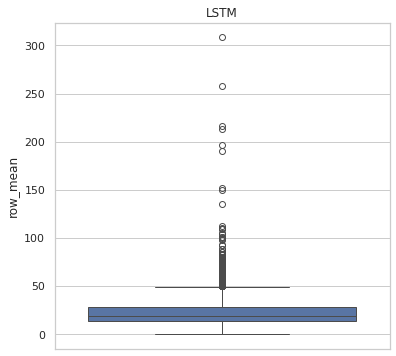

In [37]:
# boxplot of Final_test_RMSE
# to check the outlier of station
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

sns.boxplot(Final_test_RMSE)

plt.title('LSTM')
plt.ylabel('row_mean')
plt.show()

In [29]:
# count the outliers
q1 = np.percentile(Final_test_RMSE, 25)
q3 = np.percentile(Final_test_RMSE, 75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = [value for value in Final_test_RMSE if value < lower_bound or value > upper_bound]
print(len(outliers))

154


In [65]:
outliers.sort(reverse=True)
outliers

[308.3202850341797,
 257.78233337402344,
 215.97901000976563,
 213.16281433105468,
 196.7839553833008,
 190.74796142578126,
 151.3001220703125,
 149.29470520019532,
 134.7198944091797,
 112.69799194335937,
 110.05697784423828,
 109.34694061279296,
 109.1006362915039,
 105.16239471435547,
 104.04932861328125,
 101.10394592285157,
 100.42123413085938,
 99.37313995361328,
 98.81689758300782,
 97.99913940429687,
 92.3500244140625,
 92.27998504638671,
 88.75924301147461,
 88.5568946838379,
 84.85160827636719,
 84.72079086303711,
 83.27046813964844,
 83.21202239990234,
 81.93502960205078,
 80.128173828125,
 79.84841918945312,
 79.46683349609376,
 79.27171249389649,
 78.98222503662109,
 78.599658203125,
 78.5867691040039,
 77.64993896484376,
 77.30321350097657,
 76.27367553710937,
 75.65311203002929,
 75.3505470275879,
 75.2246940612793,
 74.64846343994141,
 74.22003555297852,
 74.06344680786133,
 73.27625198364258,
 72.05605850219726,
 71.97680435180663,
 71.80616912841796,
 71.7051902770996

In [54]:
RMSE_station_dict = dict(zip(Final_test_RMSE, Final_station))

In [70]:
filtered_dict = {key: value for key, value in RMSE_station_dict.items() if key in outliers}
filtered_dict = dict(sorted(filtered_dict.items(), key=lambda item: item[0], reverse=True))

In [76]:
# list of station outliers
list(filtered_dict.values())

[2316,
 342,
 1795,
 1783,
 93,
 3,
 408,
 1439,
 1807,
 876,
 1749,
 1735,
 2461,
 2476,
 1323,
 2747,
 88,
 113,
 2685,
 417,
 1313,
 626,
 2643,
 1350,
 1980,
 826,
 634,
 2303,
 1747,
 825,
 804,
 77,
 831,
 129,
 2008,
 1319,
 1858,
 2138,
 943,
 2717,
 1797,
 2404,
 836,
 160,
 2481,
 1482,
 151,
 2706,
 1742,
 822,
 555,
 457,
 1139,
 98,
 490,
 1298,
 941,
 154,
 394,
 1195,
 805,
 951,
 1965,
 711,
 268,
 748,
 918,
 1510,
 1914,
 543,
 539,
 1330,
 140,
 722,
 1708,
 94,
 1799,
 781,
 447,
 422,
 414,
 1796,
 1369,
 1748,
 791,
 1543,
 561,
 1815,
 2298,
 237,
 2400,
 13,
 1143,
 1968,
 2002,
 1380,
 347,
 1145,
 852,
 1176,
 703,
 395,
 1167,
 2663,
 409,
 850,
 2701,
 2020,
 1344,
 2075,
 803,
 170,
 1220,
 91,
 415,
 2012,
 2076,
 446,
 1806,
 523,
 121,
 557,
 1801,
 280,
 2010,
 101,
 1800,
 796,
 1816,
 2422,
 2578,
 2436,
 564,
 128,
 1368,
 798,
 1059,
 2638,
 126,
 119,
 493,
 229,
 2384,
 1962,
 894,
 2705,
 963,
 142,
 1144,
 824,
 445,
 893,
 1538,
 560]

## Visualization : Compair the Predict and Actual

In [38]:
mean_predict = np.nanmean(Final_predict_values, axis=0)
mean_predict

array([51.7742  , 47.620575, 48.13615 , 53.694744, 53.768845, 53.63585 ,
       52.957706, 48.66032 , 46.076443, 50.336025, 48.046486, 51.316467,
       56.479992, 57.291363, 56.984287, 57.089302, 56.503513, 56.742104,
       57.378483], dtype=float32)

In [40]:
actual_mean = pd.read_csv('actual_septemper_rental_record_mean.csv')
actual_mean = actual_mean.drop('Unnamed: 0', axis=1)
actual_mean = actual_mean[['y_mean','날짜']]
actual_mean

,y_mean,날짜
0,64.975268,2022-09-01
1,67.961979,2022-09-02
2,1.876338,2022-09-05
3,51.652639,2022-09-06
4,65.178295,2022-09-07
5,66.602067,2022-09-08
6,44.765596,2022-09-09
7,55.143595,2022-09-12
8,60.741971,2022-09-13
9,65.140642,2022-09-14


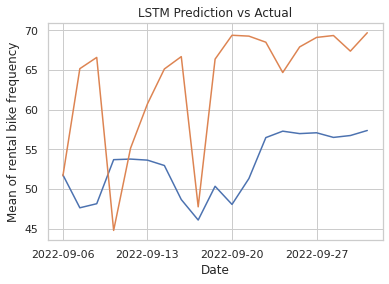

In [72]:
dates= actual_mean['날짜'].to_numpy()[3:]
plt.plot(dates, mean_predict, label='Prediction Mean')
plt.plot(dates, actual_mean['y_mean'].to_numpy()[3:], label='Actual Mean')
plt.xticks(dates[::5], rotation=0)

# 그래프 제목과 레이블 설정
plt.title('LSTM Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Mean of rental bike frequency')
# plt.legend()
plt.show()